# Movie Recommendation System

## Problem Statement
<p>Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films. The grand prize was $1,000,000 and was won by BellKor's Pragmatic Chaos team. </p>

<p>Official Page : https://www.netflixprize.com/rules.html</p>

<p>Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set.</p>

## Sources
* https://www.netflixprize.com/rules.html
* https://www.kaggle.com/netflix-inc/netflix-prize-data
* surprise library: http://surpriselib.com/ (we used many models from this library)

## Objectives
*	Predict the rating that a user would give to a movie that he has not yet rated.<br>
*	Minimize the difference between predicted and actual rating (RMSE and MAPE).

# Data Overview

## Data Files
1. combined_data_1.txt
2. combined_data_2.txt
3. combined_data_3.txt
4. combined_data_4.txt
5. movie_titles.csv
  
The first line of each file \[combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt\] contains the <b>movie id</b> followed by a colon. Each subsequent line in the file corresponds to a <b>customerID</b>, <b>rating</b> from a customer and its <b>date</b>.

## Type of Data
* There are 17770 unique movie IDs.
* There are 480189 unique user IDs.
* There are ratings. Ratings are on a five star (integral) scale from 1 to 5.

## Example Data Point
<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
...... and so on
</pre>

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# 1. Reading and Storing Data 

## Data Preprocessing

In [2]:
if not os.path.isfile("./Data/NetflixRatings.csv"): 
    startTime = datetime.now()
    data = open("./Data/NetflixRatings.csv", mode = "w")
    files = ['./Data/combined_data_2.txt', './Data/combined_data_4.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f: 
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movieID = line.replace(":", "")
                else:
                    # row = [] 
                    # row = [x for x in line.split(",")] #custID, rating and date are separated by comma
                    row = line.split(",")
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

## Creatring Dataframe from Generated CSV File

In [3]:
if not os.path.isfile("./Data/NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("./Data/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("./Data/NetflixData.pkl"):
    Final_Data.to_pickle("./Data/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("./Data/NetflixData.pkl")

In [4]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
49557332,17064,510180,2,1999-11-11
46370047,16465,510180,3,1999-11-11
22463125,8357,510180,4,1999-11-11
35237815,14660,510180,2,1999-11-11
21262258,8079,510180,2,1999-11-11


In [5]:
Final_Data.describe()["Ratings"]

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

## Checking fo NaN

In [6]:
print("Number of NaN values = \n"+str(Final_Data.isnull().sum()))

Number of NaN values = 
MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


# Basic Statistics

In [7]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))


Total Data:
Total number of movie ratings = 53825114
Number of unique users = 478723
Number of unique movies = 9114


# Spliting data into Train and Test(80:20)

In [8]:
# Train and Test data stored in TrainData.pkl and TestData.pkl for later use
if not os.path.isfile("./Data/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("./Data/TrainData.pkl")
    Train_Data = pd.read_pickle("./Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("./Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
if not os.path.isfile("./Data/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("./Data/TestData.pkl")
    Test_Data = pd.read_pickle("./Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("./Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

# Basic Statistics in Train Data 

In [9]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))
Train_Data.head()

Total Train Data:
Total number of movie ratings in train data = 43060091
Number of unique users in train data = 401901
Number of unique movies in train data = 8931
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


,MovieID,CustID,Ratings,Date
0,17064,510180,2,1999-11-11
1,16465,510180,3,1999-11-11
2,8357,510180,4,1999-11-11
3,14660,510180,2,1999-11-11
4,8079,510180,2,1999-11-11


# Basic Statistics in Test Data 

In [10]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))
Test_Data.head()

Total Test Data:
Total number of movie ratings in Test data = 10765023
Number of unique users in Test data = 327355
Number of unique movies in Test data = 9107
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


,MovieID,CustID,Ratings,Date
0,17405,1557557,4,2005-08-09
1,13462,2017421,4,2005-08-09
2,6475,934053,4,2005-08-09
3,6007,1156578,5,2005-08-09
4,5085,2311323,4,2005-08-09


# 2. Exploratory Data Analysis on Train Data

## Distribution of Ratings in Train Data

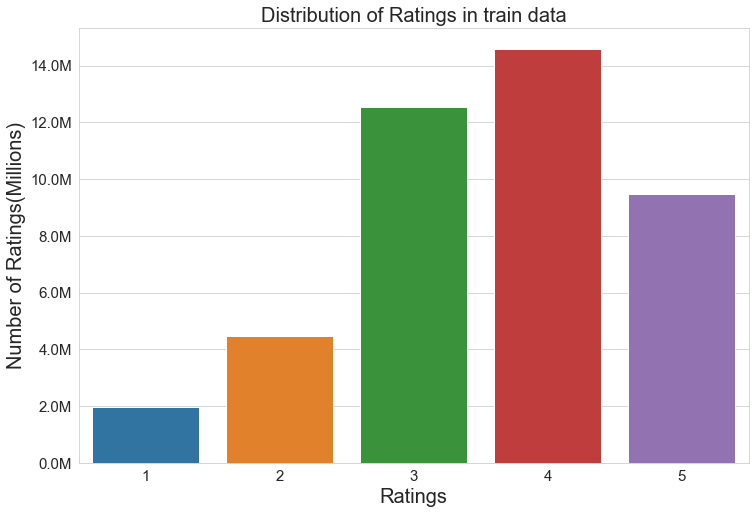

In [11]:
def changingLabels(num):
    return str(num/10**6) + "M"

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

## Number of Ratings per Month

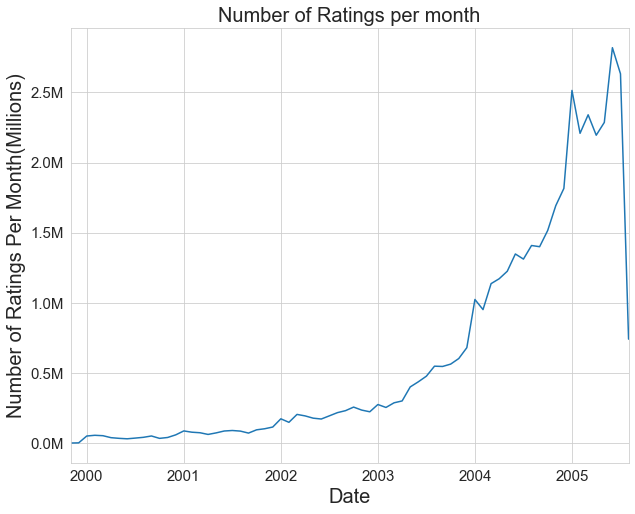

In [12]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

## Analysis of Ratings given by User

In [13]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)
print("Information about Movie Ratings grouped by Users:")
print(no_of_rated_movies_per_user.describe())

Information about Movie Ratings grouped by Users:
count    401901.00000
mean        107.14104
std         155.05350
min           1.00000
25%          19.00000
50%          48.00000
75%         133.00000
max        8779.00000
Name: Ratings, dtype: float64


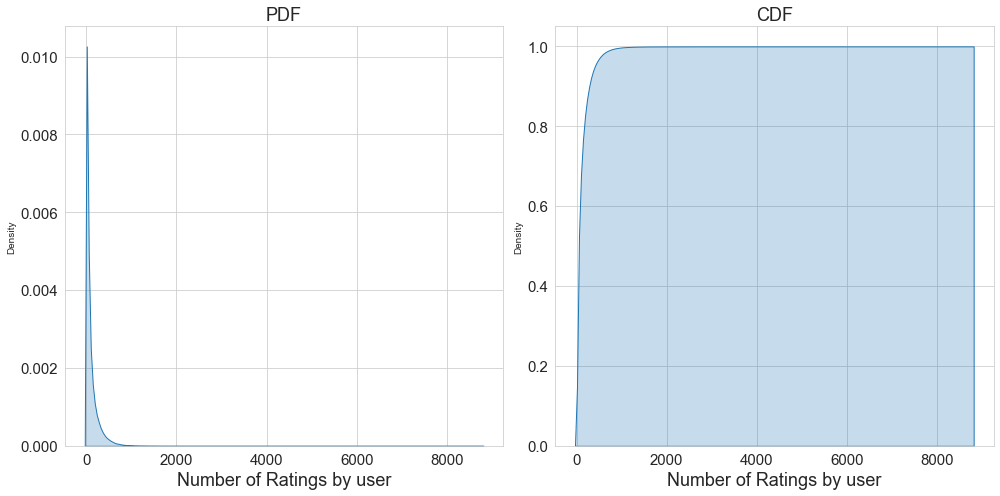

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))
sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)
sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)
fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

## Analysis of Ratings Per Movie

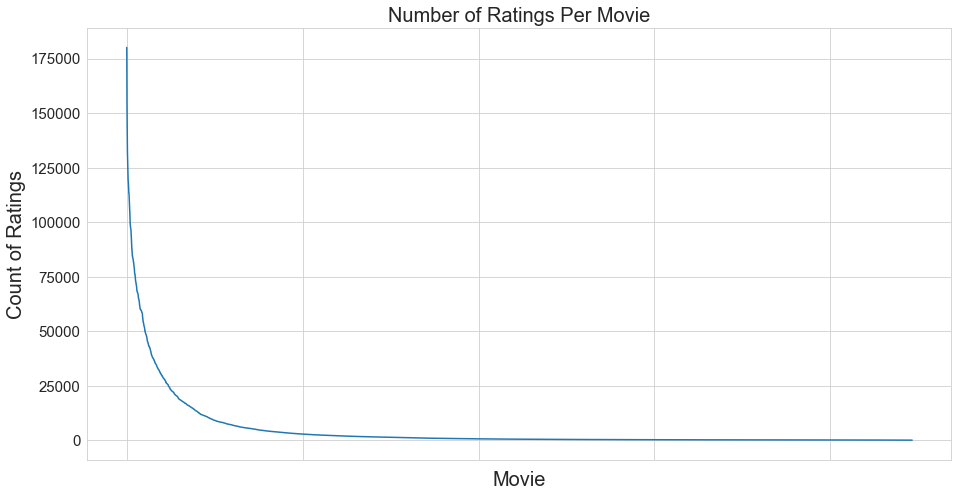

In [15]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

<center><b>It is very skewed.</b></center>

<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

# 3. Creating USER-ITEM Sparse Matrix from Dataframe

In [16]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("./Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("./Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TrainUISparseData.npz", TrainUISparseData)
    print("Done")
print(datetime.now() - startTime)

startTime = datetime.now()
print("\nCreating USER_ITEM sparse matrix for test Data")
if os.path.isfile("./Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("./Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TestUISparseData.npz", TestUISparseData)
    print("Done")
print(datetime.now() - startTime)

rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()
print("\nSparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()
print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Creating USER_ITEM sparse matrix for train Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix = (2649430, 17771)
0:00:01.364150

Creating USER_ITEM sparse matrix for test Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix = (2649430, 17771)
0:00:00.377007

Sparsity Of Train matrix : 99.90854433187319% 
Sparsity Of Test matrix : 99.97713608243731% 


## Finding Global Average of the following
### * All movie ratings 
### * Average rating per user
### * Average rating per movie


In [17]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

## Global Average Rating

In [18]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5844935859517806


## Average Rating Per User and Movie

In [19]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
print("Average rating of user 25 = {}".format(AvgRatingUser[25]))
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

Average rating of user 25 = 3.0
Average rating of movie 4500 = 3.28


## Cold Start Problem
<p> The item cold-start problem refers to when items added to the catalogue have either none or very little interactions. This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the item's interactions to make recommendations. If no interactions are available then a pure collaborative algorithm cannot recommend the item. </p>

### Cold Start Problem with Users

In [20]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 478723
Number of Users in train data= 401901
Number of Users not present in train data = 76822(16.0%)


### Cold Start Problem with Movies

In [21]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 9114
Number of Movies in train data= 8931
Number of Movies not present in train data = 183(2.0%)


# 4. Computing Similarity Matrices

## Computing User-User Similarity Matrix
<p> Calculating User User Similarity_Matrix is not very easy(unless someone has huge Computing Power and lots of time). </p>

## Computing Movie-Movie Similarity Matrix

In [22]:
start = datetime.now()
if not os.path.isfile("./Data/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("./Data/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("./Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (17771, 17771)
0:00:04.860003


## Does Movie-Movie Similarity Works?
## Let's pick random movie and check it's top 10 most similar movies.

In [23]:
movie_ids = np.unique(m_m_similarity.nonzero())
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [24]:
movie_titles_df = pd.read_csv("./Data/movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


## Similar Movies to: Godzilla's Revenge

In [25]:
movieID_GR = 17765
print("Name of the movie : "+str(movie_titles_df.loc[movieID_GR]['Movie_Title']))
print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR]['Movie_Title'], TrainUISparseData[:,movieID_GR].getnnz()))
print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR]['Movie_Title'], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie : Godzilla's Revenge
Number of ratings by users for movie Godzilla's Revenge is 285
Number of similar movies to Godzilla's Revenge is 8863


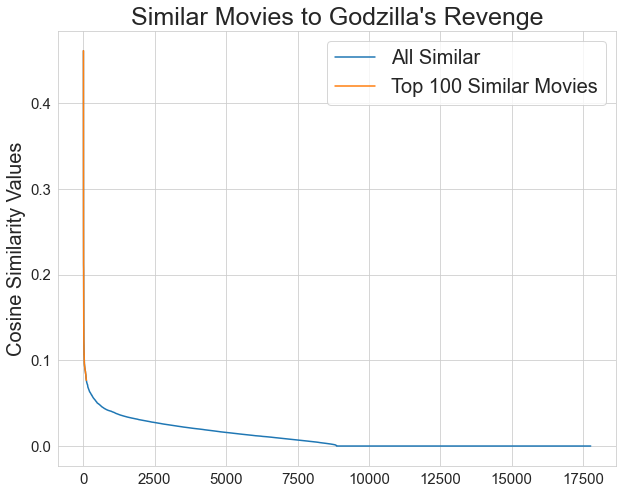

In [26]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]
similar_100 = all_similar[:101]
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Godzilla's Revenge", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

## Top 10 Similar Movies to: Godzilla's Revenge

In [27]:
movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
15810,1964.0,Godzilla vs. Mothra
5907,1956.0,Godzilla: King of the Monsters
14623,1971.0,Godzilla vs. Hedorah
8233,1968.0,Destroy All Monsters
17746,1991.0,Godzilla & Mothra: Battle for Earth / Vs. King...
15123,1995.0,Godzilla vs. Destroyah / Godzilla vs. Space Go...
8601,1997.0,Rebirth of Mothra 1 & 2: Double Feature
8656,1993.0,Godzilla vs. Mechagodzilla II
7140,2003.0,Godzilla: Tokyo S.O.S.


# 5. Machine Learning Models


In [28]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    print(datetime.now() - startTime)
    return sparse_sample

## Creating Sample Sparse Matrix for Train and Test Data

In [29]:
# Creating Sample Sparse Matrix for Train Data
path = "./Data/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))


# Creating Sample Sparse Matrix for Test Data
path = "./Data/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649117, 17764)
File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (2647588, 17689)


## Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [30]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.58


## Finding Average of all Movie Ratings in Sampled Train Data

In [31]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
random_movie = random.choice(list(globalAvgMovies))
print("Average move rating for movie {} is {}".format(random_movie,globalAvgMovies[random_movie]))

Average move rating for movie 5562 is 3.880952380952381


## Finding Average rating per User in Sample Train Data

In [32]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
random_user = random.choice(list(globalAvgUsers))
print("Average user rating for user {} is {}".format(random_user,globalAvgUsers[random_user]))

Average user rating for user 1330338 is 3.142857142857143


# Featurizing data

In [33]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 19214
No of ratings in Our Sampled test matrix is : 1150


## Featurizing Data for Regression Problem

### Featurizing Train Data

In [34]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)
if os.path.isfile("./Data/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("./Data/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = []
            row.append(user)  
            row.append(movie)
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating
            # Ratings given to "movie" by top 5 similar users with "user"
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            # If top 5 ratings not available extend with global movie average rating
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            row.extend(top_similar_user_ratings)
            # Ratings given by "user" to top 5 similar movies with "movie"
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            # If top 5 ratings not available extend with global user average rating
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            row.extend(top_similar_movie_ratings)
            # Appending "user" average, "movie" average & rating of "user""movie"
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            data.write(",".join(map(str, row)))
            data.write("\n")
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [35]:
Train_Reg = pd.read_csv("./Data/Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,17451,4515,3.686311,4.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,5.0,5.0,4.777778,3.45,5
1,97289,4515,3.686311,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,3.769231,3.45,4
2,167410,4515,3.686311,3.0,4.0,5.0,3.0,3.0,4.0,2.0,4.0,3.0,3.0,3.484848,3.45,3
3,258319,4515,3.686311,3.0,5.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.233333,3.45,3
4,473233,4515,3.686311,3.0,5.0,3.0,4.0,3.0,5.0,5.0,4.0,3.0,4.0,4.114286,3.45,5


<p><b>User_ID:</b> ID of a this User</p>
<p><b>Movie_ID:</b> ID of a this Movie</p>
<p><b>Global_Average:</b> Global Average Rating</p>
<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>
<p><b>User_Average:</b> Average Rating of this User</p>
<p><b>Movie_Average:</b> Average Rating of this Movie</p>
<p><b>Rating:</b> Rating given by this User to this Movie</p>

## Featurizing Test Data

In [36]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)
if os.path.isfile("./Data/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("./Data/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = []
            row.append(user)  
            row.append(movie)
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating
            # Ratings given to "movie" by top 5 similar users with "user"
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                # If top 5 ratings not available extend with global movie average rating
                row.extend(top_similar_user_ratings)
            # Cold Start Problem, for a new user or a new movie 
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
            # Ratings given by "user" to top 5 similar movies with "movie"
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                # If top 5 ratings not available extend with global user average rating
                row.extend(top_similar_movie_ratings)
            # Cold Start Problem, for a new user or a new movie
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
            # Appending "user" average, "movie" average & rating of "user""movie"
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
            row.append(rating)
            data.write(",".join(map(str, row)))
            data.write("\n")
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [37]:
Test_Reg = pd.read_csv("./Data/Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5


# Transforming Data for Surprise Models

## Transforming Train Data
- We can't give raw data (movie, user, rating) to train the model in Surprise library.
- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.
- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

## Transforming Test Data
- For test data we just have to define a tuple (user, item, rating).

In [38]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)
trainset = data.build_full_trainset()
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

## Applying Machine Learning Models
<p>We have two Error Metrics.</p>
<p><b>->   RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.</p>
<p><b>->   MAPE: Mean Absolute Percentage Error: </b>The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.</p>
<p>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>
<br/>
<b>We can also use other regression models. But  we are using exclusively XGBoost as it is typically fairly powerful in practice.</b>

# Table to store different model and corresponding results

In [39]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

## Utility Functions for Regression Models

In [40]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    clf = xgb.XGBRegressor(n_estimators = 100, n_jobs  = 10)
    clf.fit(x_train, y_train)
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    print('Debug',y_pred_test[:100])
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    return train_result, test_result

## Utility Functions for Surprise Models

In [41]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    train = dict()
    test = dict()
    algo.fit(trainset)
    # Evaluating Train Data
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
    # Evaluating Test Data
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    return train, test

# 1. XGBoost 12 Features

--------------------------------------------------
TRAIN DATA
RMSE = 0.6233728388058918
MAPE = 16.502248273262857
--------------------------------------------------
TEST DATA
Debug [3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.0132399 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975 3.2798975
 3.2798975 3.2798975 3.2798975 3.27989

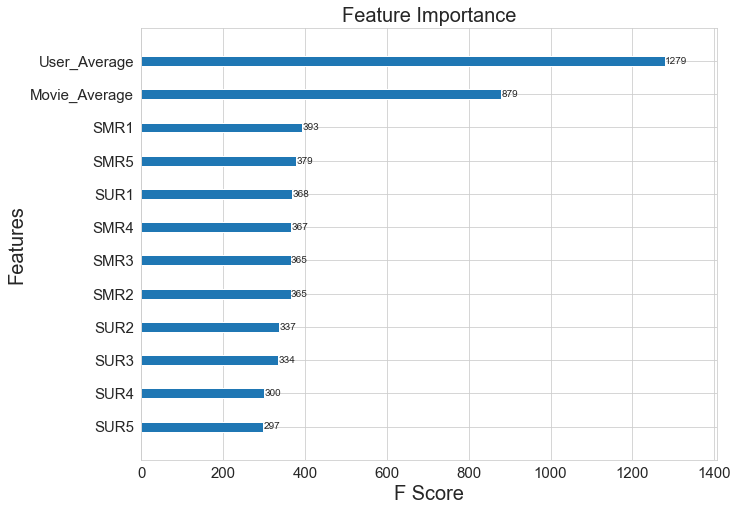

In [50]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = Train_Reg["Rating"]
y_test = Test_Reg["Rating"]
train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_12")
model_train_evaluation["XGBoost_12"] = train_result
model_test_evaluation["XGBoost_12"] = test_result

# 2. Surprise BaselineOnly Model
## Predicted Rating
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

### Optimization Function
> $\large \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

In [43]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}
algo = BaselineOnly(bsl_options=bsl_options)
train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")
model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8536746446318113
MAPE = 24.75855025009119
--------------------------------------------------
TEST DATA
RMSE = 1.0621580923235212
MAPE = 33.687459996802076
--------------------------------------------------
Time Taken = 0:00:00.212193


# 3. Matrix Factorization SVD

## Prediction $\hat{r}_{ui}$ is set as:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
- $\pmb q_i$ - Representation of item(movie) in latent factor space
        
- $\pmb p_u$ - Representation of user in new latent factor space<br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


## Optimization Problem<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>

<p>The minimization is performed by a very straightforward stochastic gradient descent:</p>
\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}


SVD Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

## Cross Validation SVD

In [44]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9481809361542698
{'n_factors': 7}


## Applying SVD with best parameters

In [45]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVD")
model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8555963569827173
MAPE = 25.224038547285023
--------------------------------------------------
TEST DATA
RMSE = 1.0619313245488449
MAPE = 33.66184791151664
--------------------------------------------------
Time Taken = 0:00:00.560510


# 4. Matrix Factorization SVDpp with implicit feedback

#### Prediction $\hat{r}_{ui}$ is set as:<br>
$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$<br><br>

 - $ \pmb{I_u}$ --- the set of all items rated by user u. $|I_u|$ is a length of that set.<br>

-  $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user u rated an item j, regardless of the rating value. $y_i$ is an item vector. For every item j, there is an item vector $y_j$ which is an implicit feedback. Implicit feedback indirectly reflects opinion by observing user behavior including purchase history, browsing history, search patterns, or even mouse movements. Implicit feedback usually denotes the presence or absence of an event. For example, there is a movie 10 where user has just checked the details of the movie and spend some time there, will contribute to implicit rating. Now, since here Netflix has not provided us the details that for how long a user has spend time on the movie, so here we are considering the fact that even if a user has rated some movie then it means that he has spend some time on that movie which contributes to implicit rating.<br><br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$, $q_i$ and $y_i$.__<br><br><br>

#### Optimization Problem

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right).\left[minimize\; b_u, b_i, q_i, p_u, y_j \right]$<br><br>

SVDpp Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

## Cross Validation SVDpp

In [46]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9389865107425365
{'n_factors': 10, 'lr_all': 0.006}


## Applying SVDpp with best parameters

In [47]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")
model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7674744310602706
MAPE = 22.17373000787356
--------------------------------------------------
TEST DATA
RMSE = 1.061022210006113
MAPE = 33.57669270406532
--------------------------------------------------
Time Taken = 0:00:05.720795


# Summary

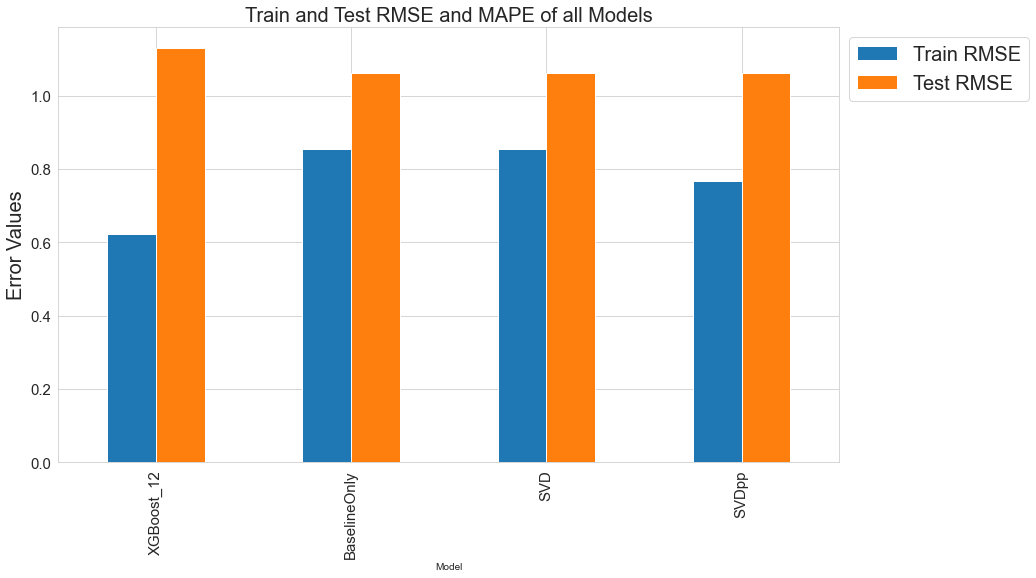

In [48]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [51]:
error_table2.style.highlight_min(color='lightgreen', axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_12,0.623373,1.129293
1,BaselineOnly,0.853675,1.062158
2,SVD,0.855596,1.061931
3,SVDpp,0.767474,1.061022


# So, far our best model is SVDpp with Test RMSE of 1.061022